# Introduction

Analyzing a dataset (EDA) is a resource-consuming task, and it takes a lot of time for real industrial ML projects with large enough datasets. According to a study, EDA takes around 30% effort of the real-world ML/Data Science projects.

In the business environment (even more then in scientific once), the time pressure is one of the factors to drive real-world ML and Data Sciene projects. You have to deliver the results not just of a good-enough (or, event better, of excellent) quality but also within a reasonably limited time frame. 

Therefore compressing the EDA time without draining its quality could be one of the benefitial ways to improve the overall ML project performance. That's where hte promise of automated rapid EDA tools starts to sound attractive. 

Typically, EDA can be decomposed into two principal parts.

- finding the project-specific insights (this will always require substantial domain expertise to delve into as well as project-specific engineering to visualize data as well as do other EDA activities)
- doing the routine checks of the data features (statistical checks, missing values, distributions, feature pair interactions etc.)

The second area is where we can really expect to achieve significant time savings by leveraging appropriate EDA automation. 

In this case study, we are going to demonstrate the benefits and pitfalls of automating routines of EDA for Drug Mechanisms of Action data with the specialized Python packages for rapid EDA below

- Sweetviz
- Autoviz

# MoA Data: Initial Subject-Matter Expert Review

Our ultimate goal is to develop algorithms and train models to determine the mechanism of action of a new drug based on the gene expression and cell viability information. So the EDA results shall set the relevant stage to do it effectively.

In this EDA, we will try to find patterns in the data, interactions between the drugs in both scored and nonscored datasets and the relationship between drugs and their target genes.

The first glimpse on the data with the domain expertise in mind draws the following indicators
- the dataset contains 876 features totally
- the features which name starts with 'g' signify gene expression data
- the features which name starts with 'c' signify cell viability data
- *cp_type* indicates samples treated with a compound
- *cp_time* and *cp_dose* indicate treatment duration (24, 48, and 72 hours) and dose (high or low). 

As for *cp_type* categories, they are are as follows
- *trt_cp* indicates the samples treated with the compounds (medicine).
- *cp_vehicle* (or with a control perturbation (*ctrl_vehicle*) indicate the control samples (control perturbations) that had no MoAs (since there were not any treatment there).

Also, the subject matter expertise helps us to see we have a multi-label classification problem. Therefore the correlation between the labels is also important and the model selection should be based on the labels correlation. 

So we will have to investigate the patterns not just in the train data but also in the multi-label target data.

At a first glance, however, we can notice that some of the MoA labels (like *atp-sensitive_potassium_channel_antagonist,    erbb2_inhibitor, antiarrhythmic* etc.) are displayed positively in a really tiny fraction of observations (less then 10 per a MoA label in fact). Therefore predicting them could be tricky as the models may consider them to be a noise (even if the appropriate re-sampling techniques applied to the training set before feeding the data into an ML algorithm).                   

The above-mentioned rapid EDA packages are nowhere near to help us with the discoveries/insights of this sort. Only the manual and subject matter-based analysis would capture them.

However, the rapid EDA tools can really add value in the routine data quality and variable interaction checks (as displayed in the sections below). Their key advantage is to let us get to the helpful data-driven insights faster.

# Reading Data

Package import, Helper functions and data reading

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt
from typing import Tuple

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline


# read data
in_kaggle = True

# base report output path
reports_folder = 'reports/'

def get_data_file_path(is_in_kaggle: bool) -> Tuple[str, str, str, str, str]:
    train_path = ''
    test_path = ''

    if is_in_kaggle:
        # running in Kaggle, inside the competition
        train_path = '../input/lish-moa/train_features.csv'
        train_targets_path = '../input/lish-moa/train_targets_scored.csv'
        train_targets_nonscored_path = '../input/lish-moa/train_targets_nonscored.csv'
        test_path = '../input/lish-moa/test_features.csv'
        sample_submission_path = '../input/lish-moa/sample_submission.csv'
    else:
        # running locally
        train_path = 'data/train_features.csv'
        train_targets_path = 'data/train_targets_scored.csv'
        train_targets_nonscored_path = 'data/train_targets_nonscored.csv'
        test_path = 'data/test_features.csv'
        sample_submission_path = 'data/sample_submission.csv'

    return train_path, train_targets_path, train_targets_nonscored_path, test_path, sample_submission_path


# Yield successive n-sized 
# chunks from the list. 
def divide_list_in_chunks(original_list, chunk_size):  
    n = chunk_size
    # looping till length of original_list 
    for i in range(0, len(original_list), n):  
        yield original_list[i:i + n]


def visualize_features_vs_target_label(df_data, label, feature_list, n_cols=3):
    
    if len(feature_list) % n_cols == 0:
    
        number_of_rows = int(len(feature_list)/n_cols)
    else:
        number_of_rows = int(len(feature_list)/n_cols) +1
    
    fig = make_subplots(rows=number_of_rows, cols=n_cols)
    
    row_pos = 1
    col_pos = 1
    
    for feature_col in feature_list:

        fig.add_trace(
            go.Violin(x=df_data[label], y=df_data[feature_col], name=feature_col),
            row=row_pos, col=col_pos
        )
        col_pos = col_pos + 1
        
        if col_pos > n_cols:
            col_pos = 1
            row_pos = row_pos + 1

    fig.update_layout(#violingap=0, 
                  #violinmode='overlay', 
                  title_text="Features-to-Target Relations")

    fig.show()
        
############################################




In [ ]:
!pip install autoviz>=0.0.71

In [ ]:
start_time = dt.datetime.now()
print("Started at ", start_time)

Let's do the initial processing steps as follows
- Reading data into memory 
- Slicing the data into separate dataframes by treated vs. controlled observations
- Separating features from the training set by c- and g-groups (cell viability and genes expression-related features, respectively) 

In [ ]:
# Import data
train_set_path, train_set_targets_path, train_set_targets_nonscored_path, test_set_path, sample_subm_path = get_data_file_path(in_kaggle)

a = pd.read_csv(train_set_path)
b = pd.read_csv(test_set_path)
c = pd.read_csv(train_set_targets_nonscored_path)
d = pd.read_csv(train_set_targets_path)

merged = pd.concat([a,b])

# Datasets for treated and control experiments
treated = a[a['cp_type'] == 'trt_cp']
control = a[a['cp_type'] == 'ctl_vehicle']

# Treatment time datasets
# cp24 = a[a['cp_time']== 24]
# cp48 = a[a['cp_time']== 48]
# cp72 = a[a['cp_time']== 72]

# Merge scored and nonscored labels
all_drugs = pd.merge(d, c, on='sig_id', how='inner')

# Treated drugs without control
treated_list = treated['sig_id'].to_list()
drugs_tr = d[d['sig_id'].isin(treated_list)]

# Non-treated control observations
control_list = control['sig_id'].to_list()
drugs_cntr = d[d['sig_id'].isin(control_list)]

# Treated drugs:
nonscored = c[c['sig_id'].isin(treated_list)]
scored = d[d['sig_id'].isin(treated_list)]

# adt = All Drugs Treated
adt = all_drugs[all_drugs['sig_id'].isin(treated_list)]

# Select the columns c-
c_cols = [col for col in a.columns if 'c-' in col]

# Filter the columns c-
cells_tr = treated[c_cols]
cells_cntr = control[c_cols]


# Select the columns g-
g_cols = [col for col in a.columns if 'g-' in col]

# Filter the columns g-
genes_tr = treated[g_cols]
genes_cntr = control[g_cols]

# Cell Viability Features: Treated vs. Control Comparison (Training Set)

We are going to run Sweetviz-based comparison of c-feature stats and interactions in Treated vs. Control sample subsets within the scored Training set provided as a data input.

In [ ]:
# !pip install sweetviz

In [ ]:
# import sweetviz as sv

#cells_tr_cntr_comparison_path = "".join([reports_folder, 'Compare_Treated_vs_Control_Cells.html'])
#df1 = sv.compare(cells_tr, cells_cntr, pairwise_analysis='on')
#df1.show_html(cells_tr_cntr_comparison_path)


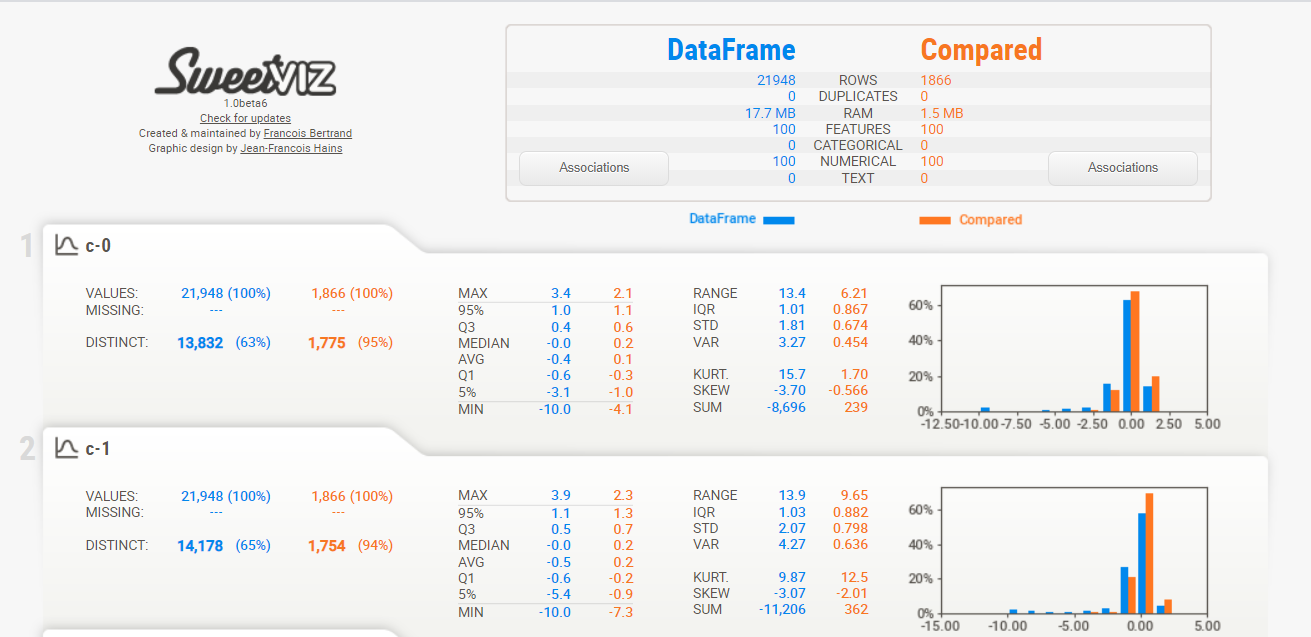

The automated report generated by SweetViz helped us to quickly grasp on the following details about the c-features in control and treated samples from the training set

- There is no any NaN values in any of the training-set observations for c-features
- The range of values for every c-feature in treated sample subset is much more extensive then the range of the values in the control sample subset
- There is a huge number of highly correlated c-feature pairs in the training dataset (with the correlation coefficient **0.8** or more), all in all
- Features to demonstrate very strong correlation with at least one more feature (with the coefficient of correlation of **0.9** or higher) are *c-1, c-2, c-4, c-5, c-6, c-8, c-10, c-11, c-12, c-13, c-15, c-17, c-18, c-21, c-24, c-26, c-27, c-31, c-33, c-38, c-40, c-41, c-42, c-44, c-45, c-51, c-52, c-54, c-55, c-57, c-59, c-60, c-62, c-63, c-66, c-67, c-72, c-73, c-75, c-80, c-81, c-82, c-83, c-84, c-85, c-90, c-91, c-92, c-93, c-94, c-96, and c-99*
- The distribution of c-features in the treated subset is significantly different from ones in the control subsample
- The strength of correlations between c-features is much higher in the treated samples subset vs. the subset of control records - The majority of c-feature variables in Treated sample subset are much more skewed vs. the control subset
- In turn, a small number of c-features are more skewed on the control samples subset (these are c-18, c-22, c-38, c-48, c-63, and c-67)
- The huge diff in skewness (more then 2 in absolute value of skew coefficient calculated by SweetViz) between the subsets of treated and control samples was, in particular, displayed by *c-0, c-3, c-7, c-8, c-10, c-13, c-14, c-15, c-16, c-17, c-19, c-20, c-21, c-23, c-24, c-25, c-27, c-29, c-30, c-31, c-32, c-33, c-34, c-35, c-37, c-39, c-41, c-42, c-44, c-45, c-46, c-51, c-52, c-53, c-56, c-59, c-60, c-61, c-64, c-66, c-68, c-69, c-70, c-71, c-72, c-73, c-75, c-78, c-83, c-85, c-86, c-87, c-88, c-89, c-90, c-91, c-93, c-94, c-95, and c-96*
- Only a tiny fraction of c-features had the coefficient of skewness less than 3 in absolute value across the treated subsamples (these are *c-6, c-9, c-18, c-26, c-37, c-38, c-48, c-50, c-58, c-65, c-74, c-76, c-79, c-81, c-92, and c-98*)
- The pairs of highly correlated c-features (ones with the coefficient of correlations 0.9 and higher) tend to be contained within the ‘clusters’ of features: **(1)** features the huge diff in skewness (more than **2** in absolute value of skew coefficient calculated by SweetViz) between the subsets of treated and control samples (see above), and **(2)** the rest of the c-features

**Notes:** 
- the HTML report generated by sweetviz in this part of the analysis can be downloaded from https://github.com/gvyshnya/MoA/blob/main/EDA_reports/sweetviz/Compare_Treated_vs_Control_Cells.html 
- in order to try to generate the same report youself, you can uncomment the code lines in the cell above

# Cell Viability Features: Treated vs. Control Comparison (Test Set)


In [ ]:
# Datasets for treated and control experiments
test_treated = b[b['cp_type'] == 'trt_cp']
test_control = b[b['cp_type'] == 'ctl_vehicle']

# Filter the columns c-
test_cells_tr = test_treated[c_cols]
test_cells_cntr = test_control[c_cols]

#sv_cntr_comparison_path = "".join([reports_folder, 'Compare_Testing_Treated_vs_Control_Cells.html'])
#df1 = sv.compare(test_cells_tr, test_cells_cntr, pairwise_analysis='on')
#df1.show_html(sv_cntr_comparison_path)

The automated report generated by SweetViz helped us to quickly grasp on the following details about the c-features in control and treated samples from the training set
- There is no any NaN values in any of the test-set observations for c-features
- The range of values for every c-feature in treated sample subset is much more extensive then the range of the values in the control sample subset
- The distribution of c-features in the treated subset is significantly different from ones in the control subsample
- There is a huge number of highly correlated c-feature pairs in the testing dataset (with the correlation coefficient **0.8** or more), all in all
- The strength of correlations between c-features is much higher in the treated samples subset vs. the subset of control records
- In general, the individual feature stat/distribution in the test set mimics what is observed for the same feature in the training set (with some notable exceptions listed below)
- Skewness coefficient for *c-6* is higher than in the training set (and it goes beyond 3 in absolute value)
- Skewness coefficients for *c-22, c-38 and c-63* are higher than in the training set (and it goes beyond 3 in absolute value)
- Skewness of *c-22, c-38 and c-63* in the treating subsample is higher (by absolute value) then in the control sample subset (as opposed to what is observed in the training set)
- Skewness of c-84 in the treating subsample is lower (by absolute value) then in the control sample subset (as opposed to what is observed in the training set)

**Notes:** 

- the HTML report generated by sweetviz in this part of the analysis can be downloaded from https://github.com/gvyshnya/MoA/blob/main/EDA_reports/sweetviz/Compare_Treated_vs_Control_Cells.html 
- in order to try to generate the same report youself, you can uncomment the code lines in the cell above

# Most Significant and Least Significant MoA Labels

## Top 20 Most Significant MoA

In [ ]:
# calculate sum per column and find the top 20s. (The top 20 most significant MoA factors?)
scored = scored.set_index('sig_id')
scored.sum().nlargest(20)

## Top 20 Least Significant MoA

In [ ]:
# now find the bottom 20s. (The top 20 most significant MoA factors?)
scored.sum().nsmallest(20)


# Cell Viability Feature vs. MoA Labels: Interactions between the top MoA effects and c-features

First of all, wee  are going to merge the dataframes with the training features and its target labels (for the subset of treated samples only).

In [ ]:
labels_in_training = pd.merge(a, d, on='sig_id', how='inner')

treated_labels_in_training = labels_in_training[labels_in_training['sig_id'].isin(treated_list)]

display(treated_labels_in_training.head())

After merging the dataframes into a signle one, we will be going through the top 2 MoA effect labels (*nfkb_inhibitor*, and *proteasome_inhibitor*) to see their interaction with the cell viability features.

## nfkb_inhibitor-to-Cell Viability Feature Interactions

We are going to create a new dataframe with the subset of the columns (target label column and c-features) from the treated training samples dataset.

In [ ]:
target_label = 'nfkb_inhibitor'
cols_to_research = c_cols.copy()
cols_to_research.append(target_label)

final_training_df = treated_labels_in_training[cols_to_research]

display(final_training_df.head())

We are going to  leverage SweetViz automation to do the express EDA of the basic *nfkb_inhibitor-to-Cell Viability* Feature Interactions

In [ ]:
sv_report_path = "".join([reports_folder, target_label,'_vs_c_features_in_treated_training_samples.html'])
# df1 = sv.analyze(final_training_df, target_label, pairwise_analysis='on')
# df1.show_html(sv_report_path)

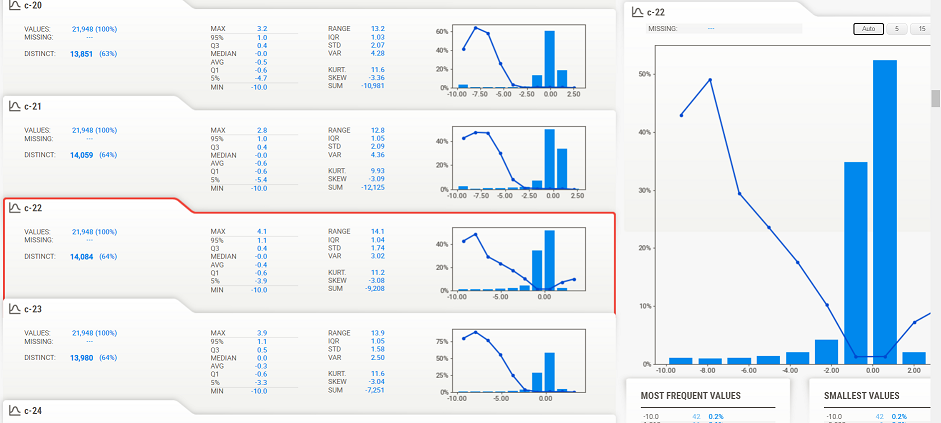

The automated report generated by SweetViz helped us to quickly grasp on the following details about the c-features in control and treated samples from the training set

- *nfkb_inhibitor* label has strong associations (correlations) with a number of c-features, with correlation coefficient **0.7** and higher; top ten among them are *c-78, c-32, c-53, c-31, c-16, c-83, c-85, c-88, c-44, c-17, c-35, c-93, c-72, and c-68*
- *nfkb_inhibitor* effect correlates with far left-side-of-the-range values of almost every c-feature (these are values in -10.. -2 range mostly)
- for the observations with values of c-features in .-1..0..1+ range, there is almost no *nfkb_inhibitor* effect observed
- notable exception from the above-mentioned pattern displays *c-22* where both smallest and highest values on the edges of the distribution curve display some association with nfkb_inhibitor label; however, the correlation coefficient for *c-22* with the target label is low enough (0.44)

**Notes:**
- the HTML report generated by sweetviz in this part of the analysis can be downloaded from https://github.com/gvyshnya/MoA/blob/main/EDA_reports/sweetviz/nfkb_inhibitor_vs_c_features_in_treated_training_samples.html 
- in order to try to generate the same report youself, you can uncomment the code lines in the cell above

Let's now take a closer look at the conditional distribution of some of the c-features displaying some association (correlation) with this target label (*'nfkb_inhibitor'*) by the label category values.

We will check for the selected subset of c-features

- top five highly correlated features (vs. the target label): *c-78, c-32, c-53, c-31, c-16*
- the deviant feature: *c-22*
- three features with the medium correlations with the target label: *c-7, c-9, c-91*
- three features that demonstrate difference in skeweness in training vs. testing set: *c-38, c-63, c-6*

In [ ]:
c_col_list = ['c-78', 'c-32', 'c-53', 'c-31', 'c-16', 'c-22', 'c-7', 'c-9', 'c-91', 'c-38', 'c-63', 'c-6']
visualize_features_vs_target_label(final_training_df, target_label, c_col_list)

As we can see from the chart above, all of the selected c-features demonstrated statistical importance vs. *'nfkb_inhibitor'* effect label.

**Notes**: 
- due to the notebook performance issues, we have not plotted the similar diagrams for all of 99 c-features
- in the local environment, the similar diagrams confired all of the c-features with medium-to-high and high correlation to *'nfkb_inhibitor'* effect label

## proteasome_inhibitor-to-Cell Viability Feature Interactions

We are going to create a new dataframe with the subset of the columns (target label column and c-features) from the treated training samples dataset.

In [ ]:
target_label = 'proteasome_inhibitor'
cols_to_research = c_cols.copy()
cols_to_research.append(target_label)

final_training_df = treated_labels_in_training[cols_to_research]

We are going to leverage SweetViz automation to do the express EDA of the basic proteasome_inhibitor-to-Cell Viability Feature Interactions

In [ ]:
#sv_report_path = "".join([reports_folder, target_label,'_vs_c_features_in_treated_training_samples.html'])
#df1 = sv.analyze(final_training_df, target_label, pairwise_analysis='on')
#df1.show_html(sv_report_path)

The automated report generated by SweetViz helped us to quickly grasp on the following details about the c-features in control and treated samples from the training set

- *proteasome_inhibitor* label has strong associations (correlations) with a number of c-features, with correlation coefficient **0.8** and higher; top ten among them are c-85, c-31, c-62, c-83, c-39, c-10, c-41, c-2, c-40, c-61, c-73, c-44, c-54, and c-42
- the majority of c-features demonstrate the correlation with the target with 0.6 - 0.78 correlation coefficient (which is high enough, compared to other labels)
- *proteasome _inhibitor* effect correlates with far left-side-of-the-range values of almost every c-feature (these are values in -10.. -2 range mostly)
- for the observations with values of c-features in .-1..0..1+ range, there is almost no proteasome _inhibitor effect observed
•	notable exception from the above-mentioned pattern displays c-22 where both smallest and highest values on the edges of the distribution curve display some association with proteasome _inhibitor label; however, the correlation coefficient for c-22 is low enough (0.44)

**Notes:** 
- the HTML report generated by sweetviz in this part of the analysis can be downloaded from https://github.com/gvyshnya/MoA/blob/main/EDA_reports/sweetviz/proteasome_inhibitor_vs_c_features_in_treated_training_samples.html
- in order to try to generate the same report youself, you can uncomment the code lines in the cell above 


Let's now take a closer look at the conditional distribution of some of the c-features displaying some association (correlation) with this target label (*'proteasome_inhibitor'*) by the label category values.

We will investigate the subset of features below

- top five highly correlated features (vs. the target label): *c-85, c-31, c-62, c-83, c-39*
- the deviant feature: *c-22*
- three features with the medium correlations with the target label: *c-32, c-53, c-31*
- three features that demonstrate difference in skeweness in training vs. testing set: *c-38, c-63, c-6*

In [ ]:
c_col_list = ['c-85', 'c-31', 'c-62', 'c-83', 'c-39', 'c-22', 'c-32', 'c-53', 'c-31', 'c-38', 'c-63', 'c-6']
visualize_features_vs_target_label(final_training_df, target_label, c_col_list)

# C-Features: EDA and AutoViz-backed Feature Importance

We will perform analysis of pair interactions between c-features as well as the interactions of g-features with the surrogate target variable (*'cp_type'*) in the training set. It will make sense as it would highlight the subset of c-features displaying statistically significant difference in key metrics (distribution, spread vs. *'cp_type'* etc.) and behaviour in control and treated subsamples. That, in turn, will infer the importance of such c-features in driving the MoA effects in the treated observations.

We will engage AutoViz to automate some of the routines in the course of such an analysis.

In [ ]:
# prepare the training subset with cat variables and c-cols only
col_subset = ['cp_type', 'cp_time'] + c_cols
training_ccols = a[col_subset]

training_ccols.head()

In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()
dftc = AV.AutoViz(filename='', sep='' , depVar='cp_type', dfte=training_ccols, header=0, verbose=2, lowess=False, 
                 chart_format='svg', max_rows_analyzed=25000, max_cols_analyzed=70)

First of all, AV detects really significant variables vs. the target (that is, *'cp_type'*). These are the variables that (1) demonstrate high variance in its key stats on treated vs. control subsets, and (2) do not have strong correlations with other significant values

In [ ]:
# get the list of significant c-variables selected by AutoViz
significant_c_cols = [col for col in dftc.columns if 'c-' in col]
print(significant_c_cols, end=',')

As we can see, AutoViz does not consider any of the c-features to be significant. This is where insights drawn by SweetViz and AutoViz are in the contrary. Anyways, it would be nice to try modelling with and without c-features to compare the ML model performance with and without c-features used.

**Note:** You can refer to https://www.youtube.com/watch?v=QZhq8g9W-pQ to see more insights on how AutoViz identifies important features within a dataset (dropping highly correlated variables, training an XGBoost model internally to detect the most significant variables vs. the target etc.).

# G-Features: EDA and AutoViz-backed Feature Importance

We will perform analysis of pair interactions between g-features as well as the interactions of g-features with the surrogate target variable (*'cp_type'*) in the training set. It will make sense as it would highlight the subset of g-features displaying statistically significant difference in key metrics (distribution, spread vs. *'cp_type'* etc.) and behaviour in control and treated subsamples. That, in turn, will infer the importance of such g-features in driving the MoA effects in the treated observations.

We will engage AutoViz to automate some of the routines in the course of such an analysis.

In [ ]:
# prepare the training subset with cat variables and g-cols only
col_subset = ['cp_type', 'cp_time'] + g_cols
training_gcols = a[col_subset]

training_gcols.head()

In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class

AV = AutoViz_Class()
dft = AV.AutoViz(filename='', sep='' , depVar='cp_type', dfte=training_gcols, header=0, verbose=2, lowess=False, 
                 chart_format='svg', max_rows_analyzed=25000, max_cols_analyzed=70)

First of all, AV detects really significant variables vs. the target (that is, *'cp_type'*). These are the variables that (1) demonstrate high variance in its key stats on treated vs. control subsets, and (2) do not have strong correlations with other significant values

In [ ]:
# get the list of significant g-variables selected by AutoViz
significant_g_cols = [col for col in dft.columns if 'g-' in col]
print(significant_g_cols, end=',')

**Note:** You can refer to https://www.youtube.com/watch?v=QZhq8g9W-pQ to see more insights on how AutoViz identifies important features within a dataset (dropping highly correlated variables, training an XGBoost model internally to detect the most significant variables vs. the target etc.).

The significance of the above-mentioned g-variables vs. *'cp_type'* is proven by the visials AutoViz generated for us (box plots with conditional distribution vs. *'cp_type'* categories, histograms, scatter plots etc.). Such a significance can be considered to be one of the feature importance/feature selection advisories to entertain down the road, when we build the predictive ML solutions.

A separate point shall be made on the correlation between significant variables picked by AutoViz. Although AutoViz rejected all of the highly correlated variables from the dataset, we can still see a few variable pairs with medium correlation (with the correlation coefficients of 0.5..0.6 or -0.5..-0.4 ranges). For example, *g-39* and *g-509* display such a medium-level correlation with a number of other g-features.

# Tried and Failed Experiments

As a part of the effort, I tried to use Pandas Profiling (another rapid ETA library in Python) for this EDA effort. However, it did not fly due to the extremely high processing time for this dataset required by Pandas Profiling.

# Final Notes

As we can see, open-source rapid ETA tools (AutoViz, SweetViz) can really boost our production as they significantly decrease the time to get some really valuable EDA insights on the data. AutoViz is extremely impressive due to it fast performance cranching the datasets of MoA competition scale.

At the same time, we should not rely on such rapid EDA tools as magic wand or a mysterious wizard to tackle all our data exploration tasks. There are still problem-specific visualizations that we will have to be constructed manually, as part of EDA phase of any ML or Data Analytics project.

Specifically, label-to-label interactions are hard to investigate with such tools in fact.

Still, the bottom line is open-source rapid ETA tools can make our EDA efforts easier and time-efficient, if used wisely. It is all about squizzing the business efficiency, after all.

# Known Issues

Both AutoViz and SweetViz are relatively new open-source tools, and you can sometimes see non-blocking issues in a way they work. 

For example, the error fired due to the limitation of Matplotlib on the maximal size of the drawing pallette,although not blocking the actual generation of the charts, still generates a confusing error output.

However, such issues do not decrease the value of such tools as they really minimize the time to get the useful insights on the data we have.

In [ ]:
print('We are done. That is all, folks!')
finish_time = dt.datetime.now()
print("Finished at ", finish_time)
elapsed = finish_time - start_time
print("Elapsed time: ", elapsed)

# References

1. Drugs classification: Mechanisms of Action - https://www.kaggle.com/amiiiney/drugs-classification-mechanisms-of-action
2. Tips for Automating EDA using Pandas Profiling, Sweetviz and Autoviz in Python - https://analyticsindiamag.com/tips-for-automating-eda-using-pandas-profiling-sweetviz-and-autoviz-in-python/
3. Better, Faster, Stronger Python Exploratory Data Analysis (EDA) - https://towardsdatascience.com/better-faster-stronger-python-exploratory-data-analysis-eda-e2a733890a64
4. Powerful EDA (Exploratory Data Analysis) in just two lines of code using Sweetviz - https://towardsdatascience.com/powerful-eda-exploratory-data-analysis-in-just-two-lines-of-code-using-sweetviz-6c943d32f34
5. Sweetviz: Automated EDA in Python - https://towardsdatascience.com/sweetviz-automated-eda-in-python-a97e4cabacde
6. AutoViz: A New Tool for Automated Visualization - https://towardsdatascience.com/autoviz-a-new-tool-for-automated-visualization-ec9c1744a6ad
7. Webinar: AutoViz and AutoViML: Automated Visualization and Machine Learning - https://www.youtube.com/watch?v=QZhq8g9W-pQ
8. You Are Plotting the Wrong Things - https://towardsdatascience.com/youre-plotting-the-wrong-things-3914402a3653